In [0]:
SETUP = True

In [0]:
if SETUP:
    !pip install praw
    #!pip install --upgrade tensorflow
    !pip install dovpanda
    !pip install -q -U toai
    !pip install -q -U git+https://github.com/huggingface/transformers
    !pip install -q -U tensorflow-datasets
    !pip install -q -U --no-deps tensorflow-addons
    !pip install -q -U tensorflow_hub
    !pip install dovpanda
    print(__import__("toai").__version__)
    print(__import__("tensorflow").__version__)

In [0]:
!pip install tensorflow==2.0.0-rc0 

In [0]:
from toai.imports import *
from toai.data import DataBundle, DataParams, DataContainer
from toai.metrics import sparse_top_2_categorical_accuracy
from toai.utils import save_file, load_file
from toai.models import save_keras_model, load_keras_model
import tensorflow as tf
from tensorflow import keras
#import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import transformers
import praw 
import dovpanda

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
TEMP_DIR = Path("temp/things")
TEMP_DIR.mkdir(parents=True, exist_ok=True)


In [0]:
BATCH_SIZE = 16
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
reddit = praw.Reddit(client_id='f0ihIXUEcYMlMA',
                     client_secret='KHetrCqCIoNghIRC3z3flRitKbE',
                     user_agent='test for reddit subreddit title scrapping for NLP clsf prob')

In [0]:
hot_posts = reddit.subreddit('MachineLearning').hot(limit=5)

In [0]:
top_posts = reddit.subreddit('MachineLearning').top(limit=3)

In [0]:
hot_posts_dl = reddit.subreddit('deeplearning').hot(limit=10)

In [27]:
print(hot_posts)

In [28]:
for post in hot_posts_dl:
    print(post.title)

SparkTorch: Distributed training of PyTorch networks on Apache Spark with ML Pipeline support
Mid-Build on a 4 GPU Deep Learning Machine (GPUs not in the machine until I finalize radiator placement)
The untold history of deep learning (starting with Hayek)
Deep learning in public policy-making?
Buffalo University Comprehensive Lecture Slides for Machine Learning and Deep Learning
Course: Deep Learning in Computer Vision
What's Hidden in a Randomly Weighted Neural Network?
Hierarchical Multilabel Image classification
Machine Learning auto labeling
How would you implement Ensemble Regression?


In [29]:
for post in top_posts:
    print(post.title)

[D] Siraj has a new paper: 'The Neural Qubit'. It's plagiarised
[R] Neural Color Transfer between Images
[P] Realtime multihand pose estimation demo


In [0]:
import itertools

In [0]:
posts = []
ml_subreddit = reddit.subreddit('MachineLearning')
dl_subreddit = reddit.subreddit('deeplearning')
for post1,post in zip(ml_subreddit.top(limit=50),dl_subreddit.top(limit=50)):
    posts.append([post1.title, post1.score, post1.id, post1.subreddit, post1.url, post1.num_comments, post1.selftext, post1.created])
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])
posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])

In [13]:
posts

,title,score,id,subreddit,url,num_comments,body,created
0,[D] Siraj has a new paper: 'The Neural Qubit'....,2355,dh2xfs,MachineLearning,https://www.reddit.com/r/MachineLearning/comme...,492,Exposed in this Twitter thread: https://twitte...,1.570953e+09
1,Deepfakes video from #TheOffice. Creeped out max.,180,dc7e1s,deeplearning,https://v.redd.it/cwzedv4m93q31,12,,1.570034e+09
2,[R] Neural Color Transfer between Images,2325,748cco,MachineLearning,https://i.redd.it/1qync11pltpz.jpg,90,,1.507155e+09
3,Samsung AI lab develops tech that can animate ...,166,bs8hxd,deeplearning,https://v.redd.it/1xno8etz21031,14,,1.558675e+09
4,[P] Realtime multihand pose estimation demo,1688,8n04hp,MachineLearning,https://media.giphy.com/media/RIX4ApOoVr5LmikK...,140,,1.527638e+09
...,...,...,...,...,...,...,...,...
95,Current feel a few months into my research,60,a6xvne,deeplearning,https://i.redd.it/vo63jcs0ps421.png,1,,1.545063e+09
96,[R][UC Berkeley] Everybody Dance Now,736,99qkrk,MachineLearning,https://www.youtube.com/watch?v=PCBTZh41Ris&fe...,75,,1.535083e+09
97,"Neural networks taught to ""read minds"" in real...",58,dk6wyb,deeplearning,https://youtu.be/mJct6RUETh0,12,,1.571535e+09
98,[News] New NVIDIA EULA prohibits Deep Learning...,731,7ly5gi,MachineLearning,https://www.reddit.com/r/MachineLearning/comme...,246,"According to German tech magazine golem.de, th...",1.514186e+09


In [0]:
 posts.to_csv('top_subreddit_posts.csv')

* =====(Line 1) Your left most column is unnamed. This suggets it might be the index column, try: pd.read_csv('top_subreddit_posts.csv', index_col=0) =====
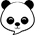

* =====(Line 1) Dataframe has 100 rows. Column subreddit has only 2 values which suggests it's a boolean feature.
After df is created, Consider converting it to boolean by using df['subreddit'] = (df['subreddit'] == 'MachineLearning') =====
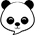

In [33]:
df = pd.read_csv('top_subreddit_posts.csv')

In [34]:
df['subreddit'].head()

0    MachineLearning
1       deeplearning
2    MachineLearning
3       deeplearning
4    MachineLearning
Name: subreddit, dtype: object

In [35]:
df.head(10)

,Unnamed: 0,title,score,id,subreddit,url,num_comments,body,created
0,0,[D] Siraj has a new paper: 'The Neural Qubit'....,2356,dh2xfs,MachineLearning,https://www.reddit.com/r/MachineLearning/comme...,492,Exposed in this Twitter thread: https://twitte...,1.570953e+09
1,1,Deepfakes video from #TheOffice. Creeped out max.,183,dc7e1s,deeplearning,https://v.redd.it/cwzedv4m93q31,12,NaN,1.570034e+09
2,2,[R] Neural Color Transfer between Images,2319,748cco,MachineLearning,https://i.redd.it/1qync11pltpz.jpg,90,NaN,1.507155e+09
3,3,Samsung AI lab develops tech that can animate ...,168,bs8hxd,deeplearning,https://v.redd.it/1xno8etz21031,14,NaN,1.558675e+09
4,4,[P] Realtime multihand pose estimation demo,1686,8n04hp,MachineLearning,https://media.giphy.com/media/RIX4ApOoVr5LmikK...,140,NaN,1.527638e+09
5,5,Coursera Staff:If you want Andrew Ng to come o...,161,dn9wny,deeplearning,https://www.reddit.com/r/deeplearning/comments...,11,Please vote here in this post if: **you want A...,1.572098e+09
6,6,[R] Deep Image Analogy,1662,68y8bb,MachineLearning,https://i.redd.it/4n1j4tvhq7vy.jpg,123,NaN,1.493815e+09
7,7,"Quick art by Nvidia GauGAN, this is the mounta...",141,c1ws2b,deeplearning,https://i.redd.it/4kyct8b031531.png,10,NaN,1.560855e+09
8,8,[D] Why can't you guys comment your fucking code?,1572,6l2esd,MachineLearning,https://www.reddit.com/r/MachineLearning/comme...,489,Seriously.\n\nI spent the last few years doing...,1.499142e+09
9,9,PyTorch or die,139,dj02ev,deeplearning,https://i.redd.it/5hpnpwcfk0t31.jpg,22,NaN,1.571309e+09


In [10]:
df['score'].plot.kde(title='score density',figsize=(10,5))


In [0]:
pd.value_counts(df['subreddit']).plot.bar(title='number of posts',figsize=(5,5))
plt.show();

In [45]:
df.describe(include='all')

,title,score,id,subreddit,url,num_comments,body,created
count,100,100.000000,100,100,100,100.000000,31,1.000000e+02
unique,100,NaN,100,2,100,NaN,31,NaN
top,[AI application] Let your machine play Super M...,NaN,5y61bg,deeplearning,https://github.com/VKCOM/YouTokenToMe,NaN,"I'm not a personal follower of Siraj, but this...",NaN
freq,1,NaN,1,50,1,NaN,1,NaN
mean,NaN,581.640000,NaN,NaN,NaN,107.540000,NaN,1.545129e+09
std,NaN,556.498532,NaN,NaN,NaN,170.928151,NaN,2.692290e+07
min,NaN,59.000000,NaN,NaN,NaN,0.000000,NaN,1.460805e+09
25%,NaN,82.000000,NaN,NaN,NaN,7.000000,NaN,1.527342e+09
50%,NaN,456.500000,NaN,NaN,NaN,33.500000,NaN,1.555581e+09
75%,NaN,960.250000,NaN,NaN,NaN,138.000000,NaN,1.567415e+09


In [14]:
df.dtypes

Unnamed: 0        int64
title            object
score             int64
id               object
subreddit        object
url              object
num_comments      int64
body             object
created         float64
dtype: object

In [0]:
data_bundle = DataBundle.from_dataframe(dataframe=df, x_col="title", y_col="subreddit")

In [0]:
train_bundle, val_bundle, test_bundle = DataBundle.split(
    data_bundle=data_bundle, fracs=[0.6, 0.2, 0.2], random=False
)

In [38]:
len(train_bundle), len(val_bundle), len(test_bundle)

(60, 20, 20)

In [0]:
def make_category_map(labels):
    return {x: i for i, x in enumerate(sorted(set(labels)))}

In [0]:
def init_label_map(filename, data_bundle):
    try:
        label_map = load_file(filename)
    except:
        label_map = data_bundle.make_label_map()
        save_file(label_map, filename)
    return label_map



In [0]:
label_map = init_label_map(TEMP_DIR / "label_map.pickle",df["subreddit"])

In [48]:
label_map

{'MachineLearning': 0, 'deeplearning': 1}

In [49]:
df["subreddit"].head()

0    MachineLearning
1       deeplearning
2    MachineLearning
3       deeplearning
4    MachineLearning
Name: subreddit, dtype: object

In [0]:
train_bundle.apply_label_map(label_map)

In [0]:
val_bundle.apply_label_map(label_map)

In [0]:
test_bundle.apply_label_map(label_map)

In [0]:
#train_bundle = DataBundle.from_unbalanced(
#    train_bundle, 100, train_bundle.value_counts()
#)

In [53]:
train_bundle.value_counts()

{0: 30, 1: 30}

In [54]:
n_categories = len(label_map)
n_categories

2

In [0]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-cased")

In [0]:
def tokenize_and_pad(arr, tokenizer, sequence_length):
    return np.array(
        [
            np.pad(
                tokenizer.encode(x, add_special_tokens=True),
                (0, sequence_length),
                "constant",
                constant_values=tokenizer.pad_token_id,
            )[:sequence_length]
            for x in arr
        ]
    )



In [0]:
train_bundle.x = tokenize_and_pad(train_bundle.x, tokenizer, 64)
val_bundle.x = tokenize_and_pad(val_bundle.x, tokenizer, 64)
test_bundle.x = tokenize_and_pad(test_bundle.x, tokenizer, 64)



In [0]:
def make_bert_dataset(data_bundle, tokenizer):
    features = tf.data.Dataset.from_tensor_slices(data_bundle.x)
    labels = tf.data.Dataset.from_tensor_slices(data_bundle.y)
    dataset = tf.data.Dataset.zip((features, labels)).map(
        lambda x, y: (
            {
                "input_ids": x,
                "attention_mask": int(x != tokenizer.pad_token_id),
                "token_type_ids": tf.zeros_like(x),
            },
            y,
        )
    )
    return dataset

In [0]:
base_bert_dataset = make_bert_dataset(train_bundle, tokenizer)

In [0]:
train_bert_dataset = (
    base_bert_dataset.cache()
    .repeat()
    .shuffle(len(train_bundle))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)



In [0]:
validation_bert_dataset = (
    make_bert_dataset(val_bundle, tokenizer).batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

In [0]:
test_bert_dataset = (
    make_bert_dataset(test_bundle, tokenizer).batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

In [0]:
data_container = DataContainer(
    base=base_bert_dataset,
    train=train_bert_dataset,
    train_steps=len(train_bundle) // BATCH_SIZE,
    validation=validation_bert_dataset,
    test=test_bert_dataset,
    label_map=label_map,
)

In [0]:
#data_container_2 = DataContainer(
#   train_data_bundle, validation_data_bundle, test_data_bundle
#)



In [53]:
data_container.n_classes

2

In [0]:
def train_model(
    model,
    data_container,
    epochs,
    lrs=None,
    optimizers=None,
    patience=5,
    verbose=1,
    class_weights=None,
    log_dir=str(TEMP_DIR / "logs"),
):
    model.layers[0].trainable = False
    if optimizers is None:
        optimizers = [keras.optimizers.Adam(lr) for lr in lrs]
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=optimizers[0],
        metrics=[
            keras.metrics.sparse_categorical_accuracy,
            sparse_top_2_categorical_accuracy,
        ],
    )
    model.fit(
        data_container.train,
        steps_per_epoch=data_container.train_steps,
        validation_data=data_container.validation,
        epochs=epochs[0],
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
            keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
        ],
        class_weight=class_weights,
        verbose=verbose,
    )
    model.layers[0].trainable = True
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=optimizers[1],
        metrics=[
            keras.metrics.sparse_categorical_accuracy,
            sparse_top_2_categorical_accuracy,
        ],
    )
    model.fit(
        data_container.train,
        steps_per_epoch=data_container.train_steps,
        validation_data=data_container.validation,
        epochs=epochs[1],
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(patience=patience // 2, factor=0.3),
            keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True),
            keras.callbacks.TensorBoard(log_dir=log_dir),
        ],
        class_weight=class_weights,
        verbose=verbose,
    )

In [0]:
config = transformers.BertConfig.from_pretrained(
    "bert-base-cased", num_labels=data_container.n_classes
)

In [0]:
class TFBertForSequenceClassification(transformers.TFBertPreTrainedModel):
    def __init__(self, config, *inputs, **kwargs):
        super(TFBertForSequenceClassification, self).__init__(config, *inputs, **kwargs)
        self.num_labels = config.num_labels

        self.bert = transformers.TFBertMainLayer(config, name="bert")
        self.dropout1 = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.hidden1 = tf.keras.layers.Dense(1024, activation=tf.keras.activations.relu)
        self.dropout2 = tf.keras.layers.Dropout(config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(
            config.num_labels,
            kernel_initializer=transformers.modeling_tf_utils.get_initializer(
                config.initializer_range
            ),
            name="classifier",
        )

    def call(self, inputs, **kwargs):
        outputs = self.bert(inputs, **kwargs)

        pooled_output = outputs[1]

        pooled_output = self.dropout1(
            pooled_output, training=kwargs.get("training", False)
        )
        hidden = self.dropout2(
            self.hidden1(pooled_output), training=kwargs.get("training", False)
        )
        logits = self.classifier(hidden)

        outputs = (logits,)

        return outputs

In [0]:
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-cased", config=config
)

In [55]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  787456    
_________________________________________________________________
dropout_38 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  2050      
Total params: 109,099,778
Trainable params: 109,099,778
Non-trainable params: 0
_________________________________________________________________


In [57]:
train_model(
    model,
    data_container,
    [0, 20],
    [3e-6, 1e-6],
    class_weights=None,
    patience=2,
)

Train for 3 steps, validate for 2 steps
Train for 3 steps, validate for 2 steps
Epoch 1/20
3/3 [==============================] - 58s 19s/step - loss: 0.7027 - sparse_categorical_accuracy: 0.5208 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 0.6935 - val_sparse_categorical_accuracy: 0.5000 - val_sparse_top_2_categorical_accuracy: 1.0000
Epoch 2/20
3/3 [==============================] - 38s 13s/step - loss: 0.6860 - sparse_categorical_accuracy: 0.5417 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 0.6930 - val_sparse_categorical_accuracy: 0.5000 - val_sparse_top_2_categorical_accuracy: 1.0000
Epoch 3/20
3/3 [==============================] - 38s 13s/step - loss: 0.6821 - sparse_categorical_accuracy: 0.5625 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 0.6924 - val_sparse_categorical_accuracy: 0.5000 - val_sparse_top_2_categorical_accuracy: 1.0000
Epoch 4/20
3/3 [==============================] - 38s 13s/step - loss: 0.6980 - sparse_categorical_accuracy: 0.47

In [0]:
df["subreddit"].head()

In [58]:
print(
    classification_report(
        [label.numpy() for _, label in data_container.validation.unbatch()],
        model.predict(data_container.validation).argmax(axis=1),
    )
)

              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.86      0.60      0.71        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



In [0]:
DataContainer??


In [0]:
def make_hub_model(url):
    return keras.Sequential(
        [
            hub.KerasLayer(url, dtype=tf.string, input_shape=[]),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(2, activation=keras.activations.softmax),
        ]
    )



In [0]:
def run_models(urls):
    for url in urls:
        model = make_hub_model(url)
        model_name = f"{url.split('/')[4]}"
        print(f" {model_name} ".center(80, "="))
        shutil.rmtree(str(TEMP_DIR / model_name), ignore_errors=True)
        train_model_1(
            model=model,
            epochs=[2, 3],
            optimizers=[keras.optimizers.Adam(lr=1e-4), keras.optimizers.Adam(lr=3e-5)],
            patience=2,
            verbose=2,
            log_dir=str(TEMP_DIR / model_name),
        )
        model.save(f"{TEMP_DIR / model_name}.h5")
        save_keras_model(
            model,
            str(TEMP_DIR / model_name / "architecture"),
            str(TEMP_DIR / model_name / "weights"),
        )
        



In [0]:
model_urls = (
    "https://tfhub.dev/google/Wiki-words-250-with-normalization/2",
    "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2",
)

In [0]:
run_models(model_urls)

In [94]:
len(train_bundle) // BATCH_SIZE

3

In [73]:
data_container.train_steps

NameError: ignored